В качестве набора данных мы будем использовать набор данных по предсказанию подозрительных транзакций (переводов средств):
https://www.kaggle.com/datasets/vardhansiramdasu/fraudulent-transactions-prediction
В исследовании будем использовать часть датасета, так как в его оригинальной версии содержится более 6 миллионов записей.

В датасете один файл Fraud, содержащий колнки:

step - единица времени. 1 step = 1 час. 

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - размер транзакции в местной валюте.

nameOrig - клиент, отправивший перевод.

oldbalanceOrg - начальный баланс до перевода.

newbalanceOrig - новый баланс после перевода.

nameDest - клиент, получивший перевод.

oldbalanceDest - начальный баланс получателя до перевода.

newbalanceDest - новый баланс получателя после перевода.

isFraud - транзакции, выполненные специальными агентами внутри системы.

isFlaggedFraud - подозрительные транзакции.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from warnings import simplefilter

simplefilter('ignore')
%matplotlib inline 

Импортируем и загружаем датасет

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Fraud_cut.csv to Fraud_cut.csv


In [3]:
orig_df = pd.read_csv('./Fraud_cut.csv', sep=',')
orig_df.head(15)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,688,CASH_IN,23557.12,C867750533,8059.00,31616.12,C1026934669,169508.66,145951.53,0,0
1,274,PAYMENT,6236.13,C601099070,0.00,0.00,M701283411,0.00,0.00,0,0
2,133,PAYMENT,33981.87,C279540931,18745.72,0.00,M577905776,0.00,0.00,0,0
3,225,CASH_OUT,263006.42,C11675531,20072.00,0.00,C529577791,390253.56,653259.98,0,0
4,249,CASH_OUT,152013.74,C530649214,20765.00,0.00,C1304175579,252719.19,404732.93,0,0
5,276,PAYMENT,2854.62,C1176841830,0.00,0.00,M1392929452,0.00,0.00,0,0
6,137,CASH_OUT,336874.19,C1430396546,201316.00,0.00,C1687236810,20820.92,357695.11,0,0
7,378,CASH_OUT,520230.74,C1815050914,0.00,0.00,C1640500532,540059.79,1060290.53,0,0
8,403,CASH_IN,51179.09,C1451233962,8278679.08,8329858.17,C330970462,602965.54,551786.46,0,0
9,202,TRANSFER,735977.55,C1864759705,8900.00,0.00,C2022704650,0.00,735977.55,0,0


In [4]:
df = orig_df.drop_duplicates()

In [5]:
df.shape

(4500, 11)

**Разведочный анализ данных. Анализ и заполнение пропусков.**


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500 entries, 0 to 4499
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            4500 non-null   int64  
 1   type            4500 non-null   object 
 2   amount          4500 non-null   float64
 3   nameOrig        4500 non-null   object 
 4   oldbalanceOrg   4500 non-null   float64
 5   newbalanceOrig  4500 non-null   float64
 6   nameDest        4500 non-null   object 
 7   oldbalanceDest  4500 non-null   float64
 8   newbalanceDest  4500 non-null   float64
 9   isFraud         4500 non-null   int64  
 10  isFlaggedFraud  4500 non-null   int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 421.9+ KB


In [7]:
df.dropna()
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Датасет не содержит пропусков.

In [8]:
df.shape

(4500, 11)

**Построение графиков для понимания структуры данных.**

Распределение транзакций разного типа

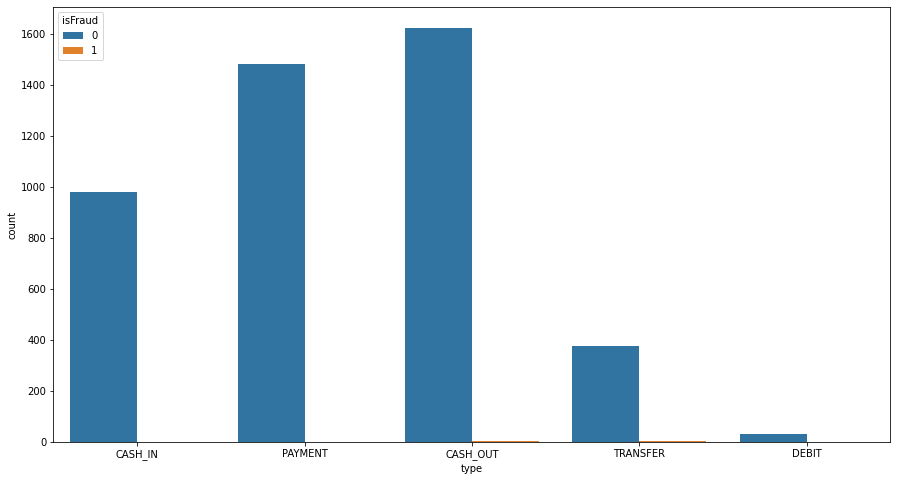

In [9]:
plt.figure(figsize=(15,8))
sns.countplot(x="type", data=df, hue="isFraud")

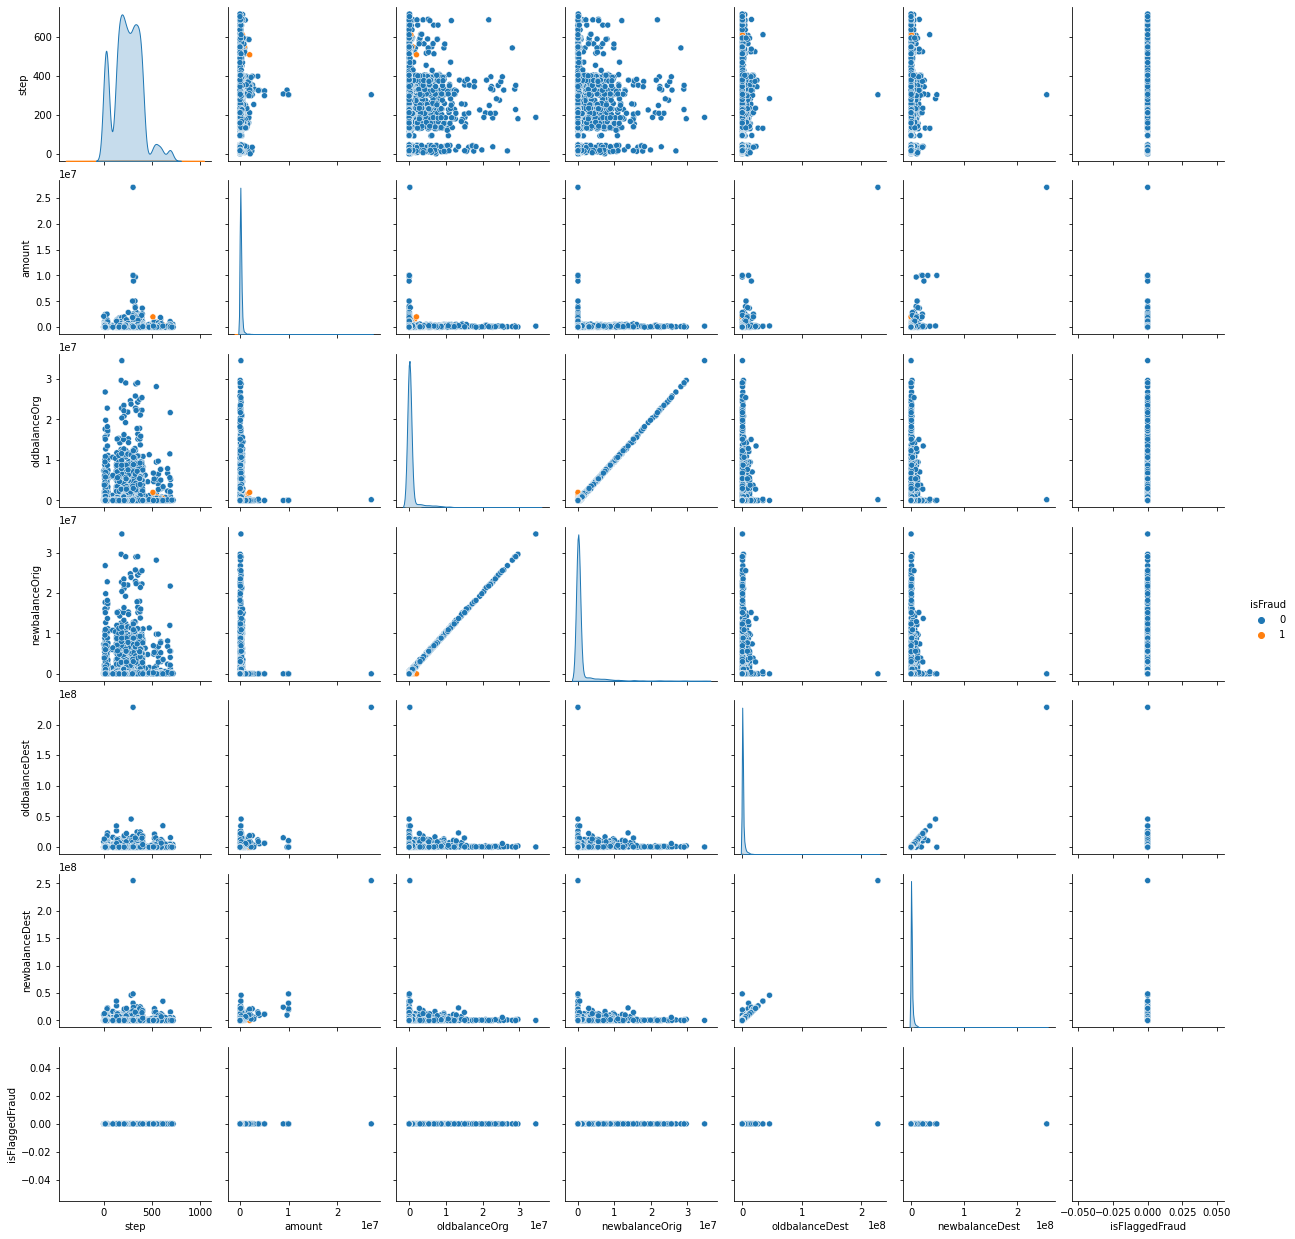

In [10]:
sns.pairplot(df, hue="isFraud")

Гистограмма для целевого признака isFraud

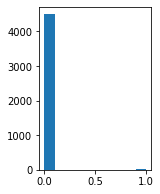

In [11]:
fig, ax = plt.subplots(figsize=(2,3)) 
plt.hist(df['isFraud'])
plt.show()

В целевом признаке присутствует критичный дисбаланас классов. Это может сказаться на качетсве обучения модели. Обученная модель с большой вероятностью будет игнорировать меньший класс (isFraud = 1), который в нашем случае представляет наибольший интерес. Поэтому в дальнейшем будем избавляться от дисбаланса.

Построим диаграмму рассеивания для столбцов amount и isFraud

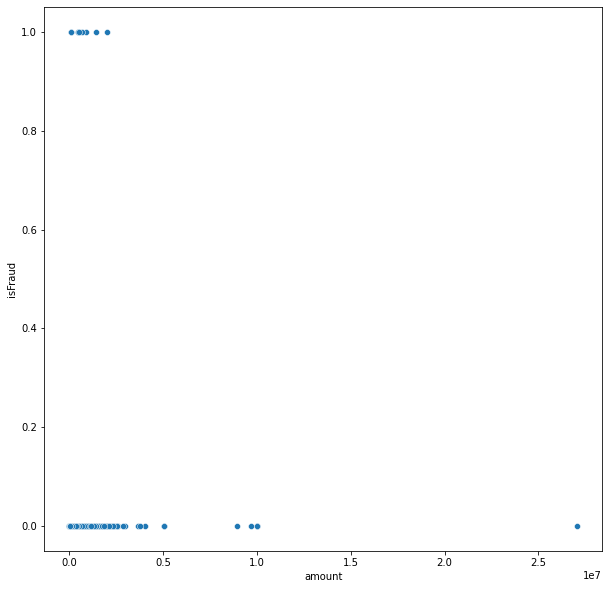

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(ax=ax, x='amount', y='isFraud', data=df)

Гистрограмма плотности вероятности распределения параметра amount.

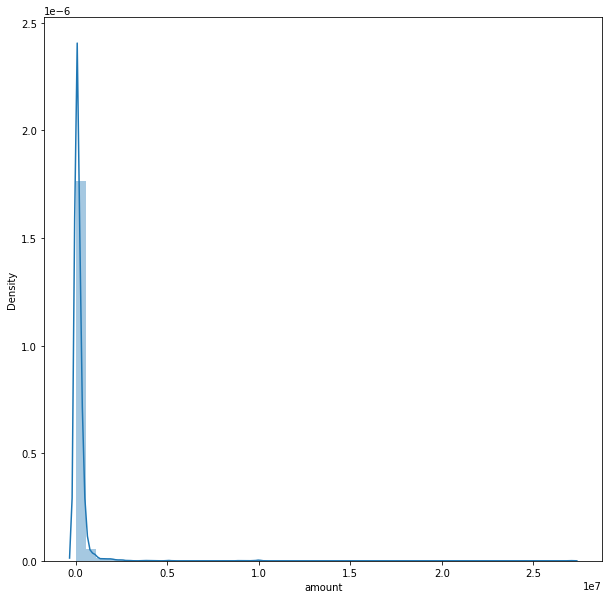

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
sns.distplot(df['amount'])

**Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей.**

Целевым признаком выберем isFraud.

In [13]:
df['isFraud'].unique()

array([0, 1])

Будем решать задачу бинарной классификации.


Удалим из модели столбцы nameOrig и nameDest.

In [14]:
df = df.drop(['nameOrig', 'nameDest'], axis=1)

In [15]:
df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,237,CASH_IN,88911.29,12827839.93,12916751.22,501186.75,412275.46,0,0
1,19,CASH_IN,27302.36,47427.00,74729.36,13580770.47,13548733.91,0,0
2,18,CASH_IN,99131.75,495456.78,594588.54,1083985.49,984853.74,0,0
3,226,CASH_IN,72666.58,1707520.61,1780187.19,256847.72,184181.14,0,0
4,38,CASH_OUT,325957.33,370901.00,44943.67,563152.82,889110.15,0,0
...,...,...,...,...,...,...,...,...,...
3995,204,PAYMENT,8843.83,0.00,0.00,0.00,0.00,0,0
3996,18,CASH_OUT,160466.11,0.00,0.00,4451750.34,4846688.96,0,0
3997,400,CASH_OUT,71221.54,0.00,0.00,959353.08,1030574.62,0,0
3998,308,CASH_IN,83192.04,10564.00,93756.04,0.00,0.00,0,0


Выполним кодирование категориальных признаков - type (5 уникальных значений).

In [15]:
le = LabelEncoder()
df["type"] = le.fit_transform(df[['type']])
df.dtypes

step                int64
type                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Проведем масштабирование данных.

In [16]:
sc = MinMaxScaler()
df =  sc.fit_transform(df)
df = pd.DataFrame(df, columns = ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud'])
df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,0.958159,0.00,0.000871,0.000234,0.000912,0.000743,0.000572,0.0,0.0
1,0.380753,0.75,0.000230,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,0.184100,0.75,0.001256,0.000544,0.000000,0.000000,0.000000,0.0,0.0
3,0.312413,0.25,0.009724,0.000582,0.000000,0.001711,0.002560,0.0,0.0
4,0.345886,0.25,0.005620,0.000602,0.000000,0.001108,0.001586,0.0,0.0
...,...,...,...,...,...,...,...,...,...
4495,0.131102,0.75,0.000093,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4496,0.220363,0.75,0.000683,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4497,0.297071,0.25,0.005361,0.000000,0.000000,0.000895,0.001369,0.0,0.0
4498,0.022315,0.75,0.000311,0.000034,0.000000,0.000000,0.000000,0.0,0.0


**Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения.**

Построим корреляционную матрицу.

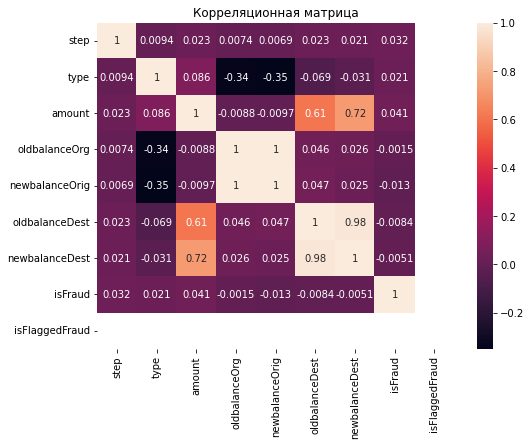

In [17]:
plt.figure(figsize=(8,6))
sns.heatmap(data=df.corr(),annot=True)
plt.title('Корреляционная матрица')
plt.show()

Видим, что целевой признак практически не коррелирует с остальными. Это может говорить о более сложной, нелинейной, зависимости целевого признака от остальных.
Также видим два больших коэффициента корреляции: 

1 - между старым и новым балансами отправителя, значит один из признаков может быть удален из модели,

0,98 - между старым и новым балансами получателя. Удалять признак не будем, так как в нашей модели здесь ожидалась 1, как и для баланса отправителя.

In [17]:
df = df.drop(['newbalanceOrig'], axis=1)

In [18]:
df.head()

,step,type,amount,oldbalanceOrg,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,0.958159,0.00,0.000871,0.000234,0.000743,0.000572,0.0,0.0
1,0.380753,0.75,0.000230,0.000000,0.000000,0.000000,0.0,0.0
2,0.184100,0.75,0.001256,0.000544,0.000000,0.000000,0.0,0.0
3,0.312413,0.25,0.009724,0.000582,0.001711,0.002560,0.0,0.0
4,0.345886,0.25,0.005620,0.000602,0.001108,0.001586,0.0,0.0


**Выбор метрик для последующей оценки качества моделей.**

In [23]:
from IPython.display import Image


Saving metrics.png to metrics.png


In [27]:
from google.colab import files
uploaded = files.upload()

Saving recall.png to recall.png


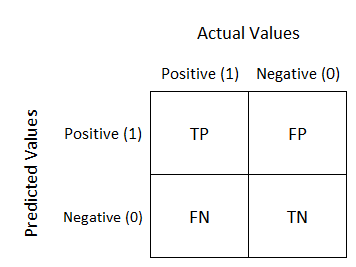

In [25]:
Image("matrix.png")

Для задачи классификации выберем метки, основанные на матрице ошибок.

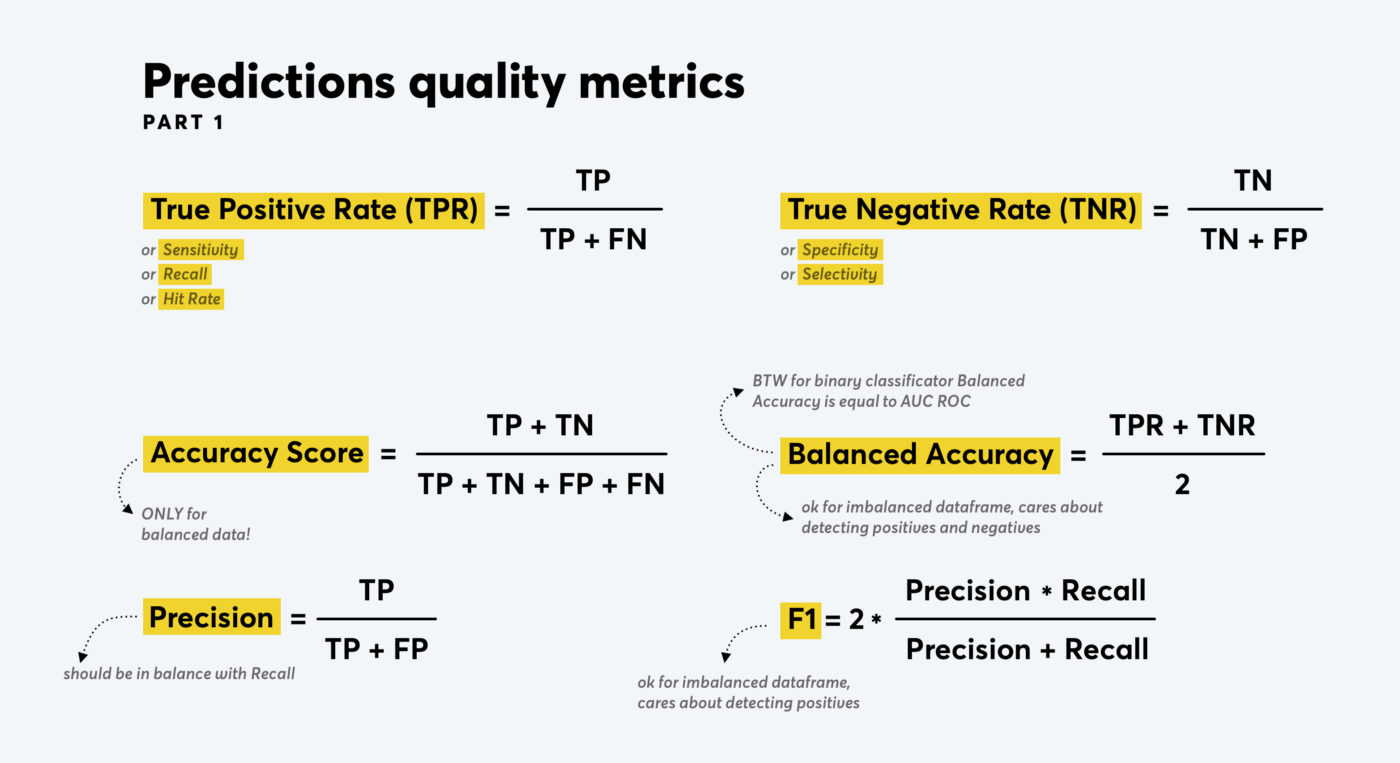

In [26]:
Image("metrics.png")

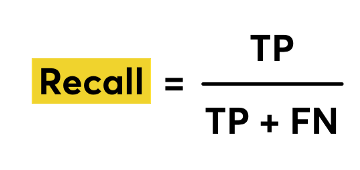

In [28]:
Image("recall.png")

Будем использовать метрики:

**balanced accuracy** - доля верных предсказаний. Метрика используется в случае дисбаланса классов при бинарной классификации.

**precision** - доля верных положительных предсказаний среди всех положительных предсказаний. Показывает, отличает ли модель один класс от другого. Применяется в случае дисбаланса классов.

**recall** - доля верных положительных предсказаний среди всех положительных объектов набора. Показывает, может ли модель определить класс. Применяется в случае дисбаланса классов.

**F1-мера** - среднее гармоническое от precision и recall. Не учитывает верные негативные предсказания. Применяется в случае дисбаланса классов.

In [18]:
def print_metrics(model, y_test, y_pred): 
  acc = balanced_accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
  rec = recall_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
  f1 = f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
  print(f"Balanced Accuracy: {acc}")
  print(f"Precision: {prec}")
  print(f"Recall: {rec}")
  print(f"F1: {f1}")
  result = pd.DataFrame({'values': [ acc, prec, rec, f1 ], 'metrics': ['Balanced Accuracy', 'Precision', 'Recall', 'F1']  })
  ax = result.plot.barh(x='metrics', y='values')
  plot_confusion_matrix(model, x_train, y_train.values,
                      display_labels=['0','1'], 
                      cmap=plt.cm.Blues, normalize='true')
  plt.show()
  

**Выбор наиболее подходящих моделей для решения задачи классификации.**

Будем использовать следующие модели:

Метод ближайших соседей

Машина опорных векторов

Решающее дерево

Случайный лес

Градиентный бустинг

**Формирование обучающей и тестовой выборок на основе исходного набора данных.**

In [20]:
y = df['isFraud']
x = df.drop('isFraud', axis=1)

Перед составлением моделей решим проблему дисбаланса классов. Для этого воспользуемся алгоритмом SMOTE. Он основан на идее генерации некоторого количества искусственных примеров, которые были бы «похожи» на имеющиеся в миноритарном классе (в нашем случае это подозрительные транзакции), но при этом не дублировали их.

In [22]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
x_balanced, y_balanced = pipeline.fit_resample(x, y)

In [21]:
y.value_counts()

0.0    4491
1.0       9
Name: isFraud, dtype: int64

In [23]:
y_balanced.value_counts()

0.0    898
1.0    449
Name: isFraud, dtype: int64

Теперь формируем выборки

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.3, random_state=2)


**Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров.**

KNN_5
Balanced Accuracy: 0.9191906855560983
Precision: 0.9243982198180671
Recall: 0.9234567901234568
F1: 0.9237760441387779


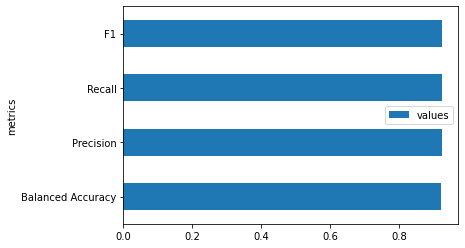

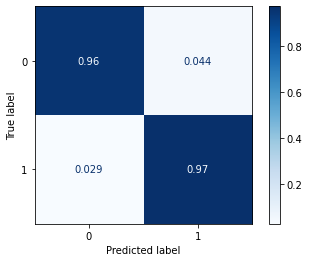

SVC
Balanced Accuracy: 0.6904412962058297
Precision: 0.7520530114779316
Recall: 0.7580246913580246
F1: 0.7434227330779055


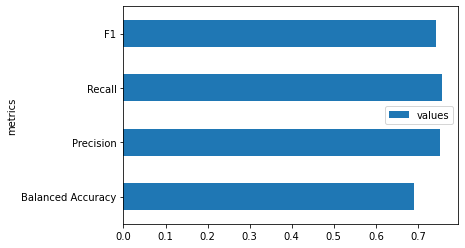

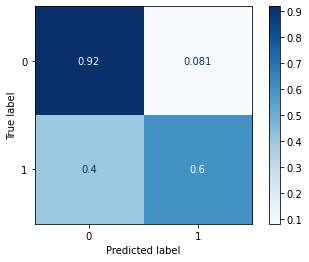

Tree
Balanced Accuracy: 0.9721543722520762
Precision: 0.96939185665653
Recall: 0.9679012345679012
F1: 0.9681329249048548


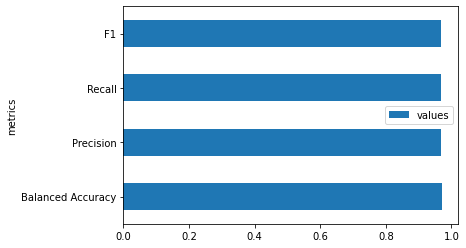

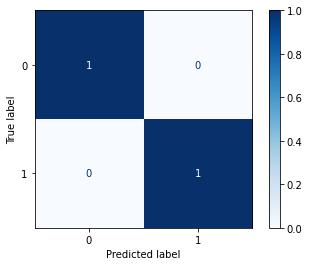

RandomForest
Balanced Accuracy: 0.9851408565380231
Precision: 0.9831869289884558
Recall: 0.9827160493827161
F1: 0.9827881389990789


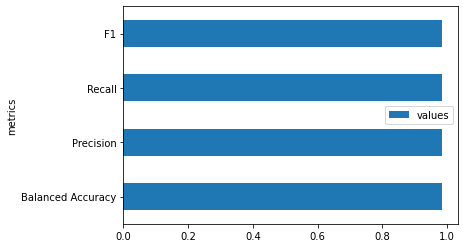

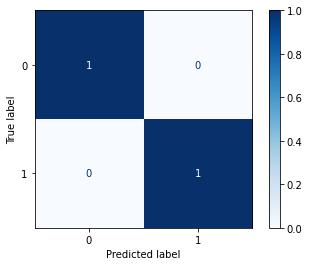

GradientBoosting
Balanced Accuracy: 0.9813955381859631
Precision: 0.9786648983200708
Recall: 0.9777777777777777
F1: 0.977905024998715


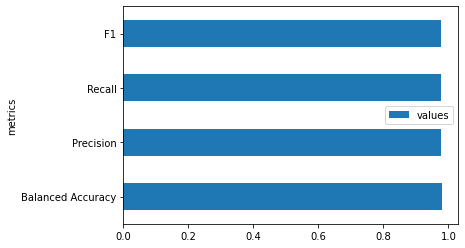

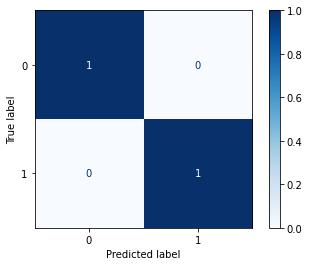

In [65]:
models = {'KNN_5':KNeighborsClassifier(n_neighbors=5),
               'SVC':SVC(),
               'Tree':DecisionTreeClassifier(),
               'RandomForest':RandomForestClassifier(),
               'GradientBoosting':GradientBoostingClassifier()}
for name, model in models.items():
  est = model.fit(x_train, y_train)
  y_pred = est.predict(x_test)
  print(name)
  print_metrics(model, y_test, y_pred)
  

Лучшие результаты показывают модели решающего дерева, случайного леса и градиентного бустинга. Машина опорных векторов совершает больше всего ошибок.

**Подбор гиперпараметров для выбранных моделей.**

Метод ближайших соседей

In [26]:
n_range = np.array(range(1, 200, 4))
knn_parameters = [{'n_neighbors': n_range}]
n_range

array([  1,   5,   9,  13,  17,  21,  25,  29,  33,  37,  41,  45,  49,
        53,  57,  61,  65,  69,  73,  77,  81,  85,  89,  93,  97, 101,
       105, 109, 113, 117, 121, 125, 129, 133, 137, 141, 145, 149, 153,
       157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197])

In [46]:
gs1 = GridSearchCV(KNeighborsClassifier(), knn_parameters,
                  cv=ShuffleSplit(n_splits=8), scoring='roc_auc',
                  return_train_score=True, n_jobs=-1)
gs1.fit(x_balanced, y_balanced)

GridSearchCV(cv=ShuffleSplit(n_splits=8, random_state=None, test_size=None, train_size=None),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': array([  1,   5,   9,  13,  17,  21,  25,  29,  33,  37,  41,  45,  49,
        53,  57,  61,  65,  69,  73,  77,  81,  85,  89,  93,  97, 101,
       105, 109, 113, 117, 121, 125, 129, 133, 137, 141, 145, 149, 153,
       157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197])}],
             return_train_score=True, scoring='roc_auc')

График изменения качества на тестовой выборке в зависимости от К-соседей

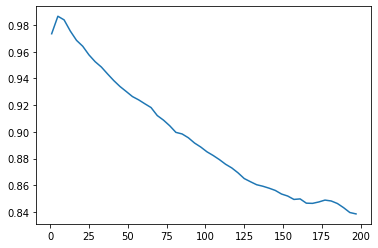

In [49]:
plt.plot(n_range, gs1.cv_results_["mean_test_score"]);

In [47]:
#Лучший параметр
gs1.best_params_

{'n_neighbors': 5}

In [48]:
#Лучший результат
gs1.best_score_

0.9866459341112415

Машина опорных векторов

In [31]:
svm_parameters = [{'C': n_range}]
gs2 = GridSearchCV(SVC(), svm_parameters,
                  cv=8, scoring='roc_auc', n_jobs=-1)
gs2.fit(x_balanced, y_balanced)

GridSearchCV(cv=8, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': array([  1,   5,   9,  13,  17,  21,  25,  29,  33,  37,  41,  45,  49,
        53,  57,  61,  65,  69,  73,  77,  81,  85,  89,  93,  97, 101,
       105, 109, 113, 117, 121, 125, 129, 133, 137, 141, 145, 149, 153,
       157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197])}],
             scoring='roc_auc')

График изменения качества на тестовой выборке в зависимости от параметра C

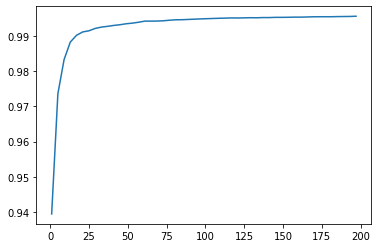

In [34]:
plt.plot(n_range, gs2.cv_results_["mean_test_score"]);

In [32]:
#Лучший параметр
gs2.best_params_

{'C': 197}

In [33]:
#Лучший результат
gs2.best_score_

0.9956218572664277

Решающее дерево

In [35]:
tree_parameters = {'max_depth': n_range, 'criterion': ['gini', 'entropy'], 'min_samples_split' : [2, 3, 4, 5]}
gs3 = GridSearchCV(DecisionTreeClassifier(), tree_parameters,
                  cv=ShuffleSplit(n_splits=8), scoring='roc_auc',
                  return_train_score=True, n_jobs=-1)
gs3.fit(x_balanced, y_balanced)

GridSearchCV(cv=ShuffleSplit(n_splits=8, random_state=None, test_size=None, train_size=None),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([  1,   5,   9,  13,  17,  21,  25,  29,  33,  37,  41,  45,  49,
        53,  57,  61,  65,  69,  73,  77,  81,  85,  89,  93,  97, 101,
       105, 109, 113, 117, 121, 125, 129, 133, 137, 141, 145, 149, 153,
       157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197]),
                         'min_samples_split': [2, 3, 4, 5]},
             return_train_score=True, scoring='roc_auc')

In [36]:
#Лучшие параметры
gs3.best_params_

{'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 5}

In [37]:
#Лучший результат
gs3.best_score_

0.9965230140344563

Случайный лес

In [38]:
f_params = {'n_estimators': [50, 100, 120, 150],  'criterion': ['gini', 'entropy'], 'min_samples_leaf': [ 2, 3, 4]}
gs4 = GridSearchCV(RandomForestClassifier(), f_params, cv=6, n_jobs=-1, scoring='roc_auc')
gs4.fit(x_balanced, y_balanced)

GridSearchCV(cv=6, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [2, 3, 4],
                         'n_estimators': [50, 100, 120, 150]},
             scoring='roc_auc')

In [39]:
#Лучшие параметры
gs4.best_params_

{'criterion': 'entropy', 'min_samples_leaf': 2, 'n_estimators': 50}

In [40]:
#Лучший результат
gs4.best_score_

0.9999702709420829

Градиентный бустинг


In [41]:
param_range = np.arange(10, 300, 20)
gb_params = {'n_estimators': param_range,  'subsample': [0.0, 0.5, 1.0], 'loss': [ 'log_loss', 'exponential']}
gs5 = GridSearchCV(GradientBoostingClassifier(), gb_params, cv=8, n_jobs=-1, scoring='roc_auc')
gs5.fit(x_balanced, y_balanced)

GridSearchCV(cv=8, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'loss': ['log_loss', 'exponential'],
                         'n_estimators': array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190, 210, 230, 250,
       270, 290]),
                         'subsample': [0.0, 0.5, 1.0]},
             scoring='roc_auc')

In [42]:
#Лучшие параметры
gs5.best_params_

{'loss': 'exponential', 'n_estimators': 170, 'subsample': 1.0}

In [43]:
#Лучший результат
gs5.best_score_

1.0

**Сравнение качества полученных моделей с качеством baseline-моделей.**

In [50]:
all_models = {'KNN_5':KNeighborsClassifier(n_neighbors=5),
               'Best KNN': gs1.best_estimator_,
               'SVC':SVC(), 'Best SVC': gs2.best_estimator_,
               'Tree':DecisionTreeClassifier(),  'Best Tree': gs3.best_estimator_,
               'RandomForest':RandomForestClassifier(), 'Best RandomForest': gs4.best_estimator_,
               'GradientBoosting':GradientBoostingClassifier(), 'Best GradientBoosting':  gs3.best_estimator_ }

KNN_5
Balanced Accuracy: 0.9191906855560983
Precision: 0.9243982198180671
Recall: 0.9234567901234568
F1: 0.9237760441387779


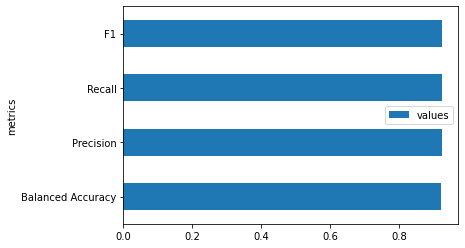

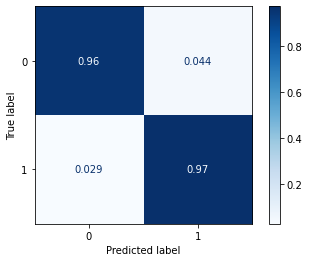

Best KNN
Balanced Accuracy: 0.9191906855560983
Precision: 0.9243982198180671
Recall: 0.9234567901234568
F1: 0.9237760441387779


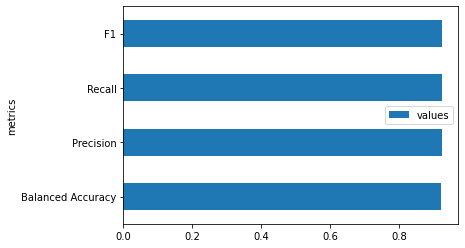

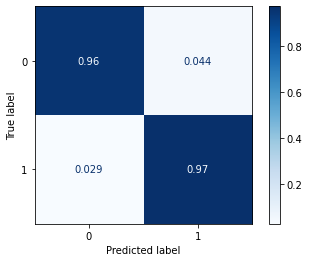

SVC
Balanced Accuracy: 0.6904412962058297
Precision: 0.7520530114779316
Recall: 0.7580246913580246
F1: 0.7434227330779055


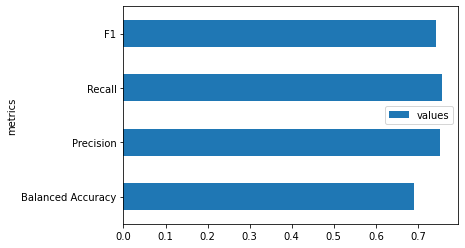

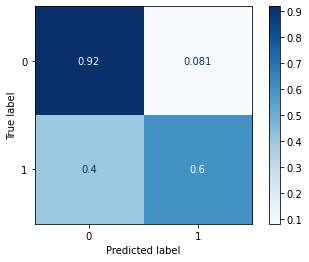

Best SVC
Balanced Accuracy: 0.9560332193453835
Precision: 0.9604938271604938
Recall: 0.9604938271604938
F1: 0.9604938271604938


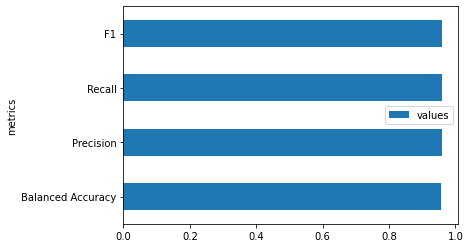

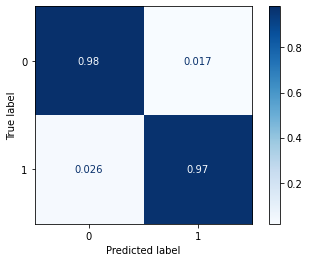

Tree
Balanced Accuracy: 0.981517668132226
Precision: 0.9805891255149543
Recall: 0.980246913580247
F1: 0.9803134671059199


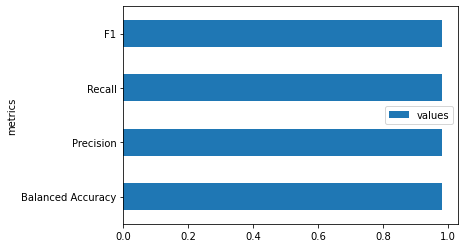

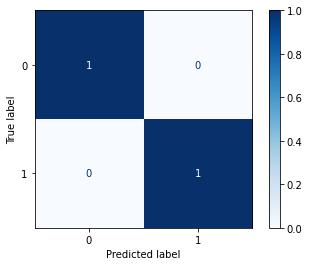

Best Tree
Balanced Accuracy: 0.9796450089561961
Precision: 0.9782878698909234
Recall: 0.9777777777777777
F1: 0.9778704644273871


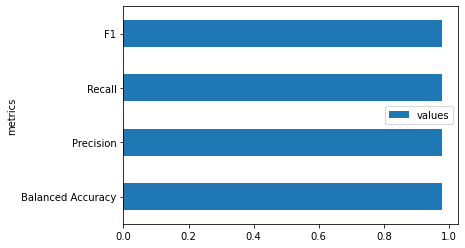

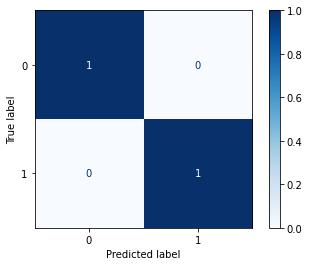

RandomForest
Balanced Accuracy: 0.9925093632958801
Precision: 0.9904016692749088
Recall: 0.9901234567901235
F1: 0.99015673355296


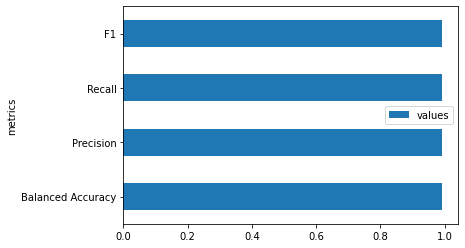

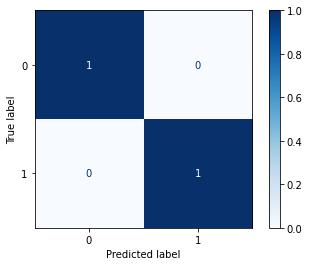

Best RandomForest
Balanced Accuracy: 0.983390327308256
Precision: 0.9829226066814719
Recall: 0.9827160493827161
F1: 0.9827601491291424


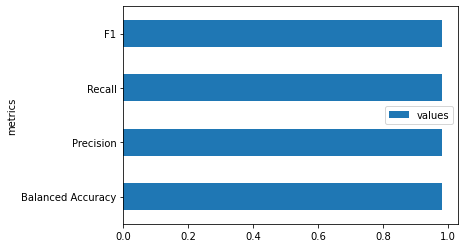

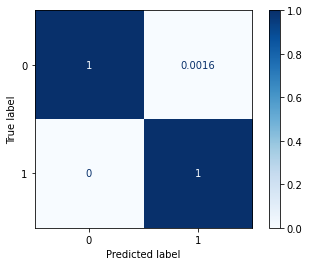

GradientBoosting
Balanced Accuracy: 0.9813955381859631
Precision: 0.9786648983200708
Recall: 0.9777777777777777
F1: 0.977905024998715


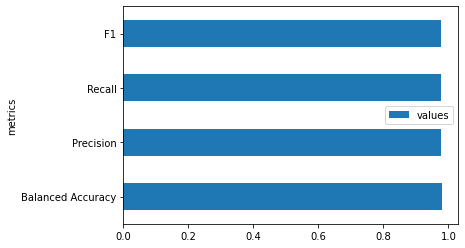

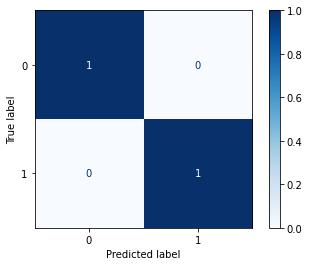

Best GradientBoosting
Balanced Accuracy: 0.9777723497801661
Precision: 0.9760181637576273
Recall: 0.9753086419753086
F1: 0.9754310241898894


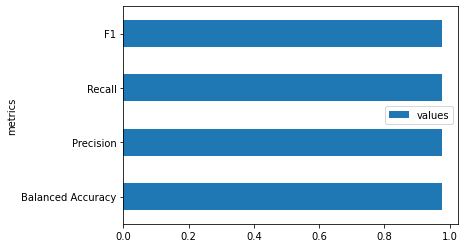

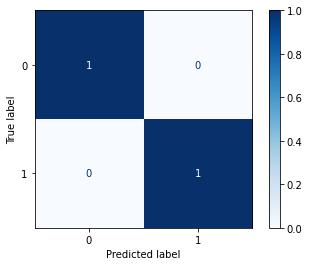

In [66]:
for name, model in all_models.items():
  est = model.fit(x_train, y_train)
  y_pred = est.predict(x_test)
  print(name)
  print_metrics(model, y_test, y_pred)

Вывод: на основании используемых метрик наилучшей моделью оказалась baseline-модель случайного леса. Значения всех метрик стремятся к 1.

Методы ближайших соседей, решающего дерева, градиентоного бустинга и опорных векторов (с подобранным параметром) также дали отличные результаты. Значения метрик превышают 0,9. 

Кросс-валидация показала лучший результат для модели машины опорных векторов, так как до подбора параметра значения метрик были относительно небольшими.